2º parte

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [12]:
# Cargar el modelo entrenado en el primer archivo (proyecto_lluvia)
model = joblib.load('modelo_lluvia')  # Asegúrate de que el nombre del archivo sea correcto

In [13]:
#EN ESTE CODIGO MODIFICO UNOS DATOS QUE ENCONTRÉ EN INTERNET

# Cargar el archivo CSV
df_norte = pd.read_csv('nordics_weather.csv')

# Eliminar las columnas innecesarias
df_norte = df_norte.drop(columns=['snow_depth', 'tavg', 'tmax', 'tmin'])

# Convertir la columna 'date' a tipo de dato fecha
df_norte['date'] = pd.to_datetime(df_norte['date'])

# Crear columnas separadas para año y mes
df_norte['ano'] = df_norte['date'].dt.year
df_norte['mes'] = df_norte['date'].dt.month

# Sumar la precipitación diaria para obtener la precipitación mensual
df_mensual = df_norte.groupby(['country', 'ano', 'mes']).agg({'precipitation': 'sum'}).reset_index()

# Pivotear el DataFrame para tener columnas separadas para cada mes
df_mensual = df_mensual.pivot_table(index=['country', 'ano'], columns='mes', values='precipitation', fill_value=0).reset_index()

# Cambiar el nombre de la columna 'country' a 'region' para que coincida con tus otros conjuntos de datos
df_mensual.rename(columns={'country': 'region'}, inplace=True)

# Agregar una columna 'Parametro' con el valor 'Precipitacion'
df_mensual['Parametro'] = 'Precipitacion'

# Calcular la columna 'anual' como la suma de las precipitaciones mensuales
df_mensual['anual'] = df_mensual[list(range(1, 13))].sum(axis=1)

# Cambiar los nombres de las columnas 1 a 12 por los nombres de los meses
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
df_mensual.rename(columns=dict(zip(range(1, 13), meses)), inplace=True)

# Reorganizar el orden de las columnas
column_order = ['Parametro', 'region'] + meses + ['anual']

df_mensual = df_mensual[column_order]

# Guardar el DataFrame resultante en un archivo CSV si es necesario
df_mensual.to_csv('nordics_weather_transformed.csv', index=False)




In [14]:
# Cargar los datos desde los archivos CSV de 2019, 2020 y 2021
df_1981 = pd.read_csv('PREC_1981_2010_Provincias.csv', delimiter=';')
df_2019 = pd.read_csv('PREC_2019_Provincias.csv', delimiter=';')
df_2020 = pd.read_csv('PREC_2020_Provincias.csv', delimiter=';')
df_2021 = pd.read_csv('PREC_2021_Provincias.csv', delimiter=';')
df_2022 = pd.read_csv('PREC_2022_Provincias.csv', delimiter=';')
df_paises_del_norte = pd.read_csv('nordics_weather_transformed.csv', delimiter=',')

# Crea df inicial si aún no está definido
if 'df' not in locals():
    df = pd.DataFrame()
# Llenar los valores nulos con la media de la columna
df.fillna(df.mean(), inplace=True)

# Combinar los nuevos datos con los datos existentes
df = pd.concat([df, df_2019, df_2020, df_2021,df_1981,df_2022,df_paises_del_norte], ignore_index=True)

# Predecir el valor anual de lluvia usando el modelo de regresión lineal
df['anual_predicho'] = model.predict(df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']])

# Ajustar umbrales manuales para determinar el estado climático
umbral_sequia = 400.0 # Establecer un valor bajo para la sequía
umbral_inundacion = 1000.0  # Establecer un valor alto para la inundación

# Crear una columna "estado_climatico" basada en los nuevos umbrales usando if
df['estado_climatico'] = 'Normal'  # Inicializar con 'Normal'
df.loc[df['anual_predicho'] < umbral_sequia, 'estado_climatico'] = 'Sequía'
df.loc[df['anual_predicho'] > umbral_inundacion, 'estado_climatico'] = 'Inundación'


# Dividir los datos en características (X) y etiquetas (y)
X = df[['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]
y = df['estado_climatico']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar un modelo de regresión logística
modelo_clasificacion = LogisticRegression(random_state=42)
modelo_clasificacion.fit(X_train, y_train)



# Realizar predicciones en el conjunto de prueba
y_pred = modelo_clasificacion.predict(X_test)

# Evaluar el rendimiento del modelo
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion)


C:\Users\sgcov\AppData\Local\Temp\ipykernel_14960\3085610733.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


              precision    recall  f1-score   support

  Inundación       0.94      0.91      0.92        32
      Normal       0.92      0.96      0.94        94
      Sequía       0.94      0.87      0.91        39

    accuracy                           0.93       165
   macro avg       0.93      0.91      0.92       165
weighted avg       0.93      0.93      0.93       165



C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


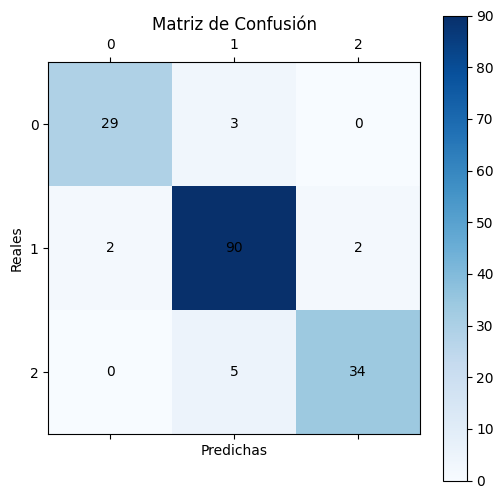

Accuracy: 0.9272727272727272
Precision: 0.9278505928275513
Recall: 0.9272727272727272
F1-score: 0.9269413179413181


In [15]:
def visualiza_metricas(y_reales, y_predichas, titulo):
    matriz_confusion = confusion_matrix(y_reales, y_predichas)
    accuracy = accuracy_score(y_reales, y_predichas)
    precision = precision_score(y_reales, y_predichas, average='weighted')
    recall = recall_score(y_reales, y_predichas, average='weighted')
    f1 = f1_score(y_reales, y_predichas, average='weighted')

    plt.figure(figsize=(6, 6))
    plt.matshow(matriz_confusion, cmap="Blues", fignum=1)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predichas")
    plt.ylabel("Reales")
    plt.colorbar()

    for i in range(matriz_confusion.shape[0]):
        for j in range(matriz_confusion.shape[1]):
            plt.text(j, i, str(matriz_confusion[i, j]), va='center', ha='center')

    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

# Realizar predicciones en el conjunto de prueba
y_pred_clases = modelo_clasificacion.predict(X_test)

# Visualizar las métricas y la matriz de confusión
visualiza_metricas(y_test, y_pred, "Métricas de Clasificación")


Estos son pruebas con datos inventados

In [17]:
# Crear un vector de características para la predicción
nuevo_dato = np.array([13.4, 57.9, 13.9, 28.4, 18.6, 11.1, 2.0, 6.1, 6.8, 15.6, 3.6, 11.5]).reshape(1, -1)

# Crear un vector de características para la predicción
nuevo_dato2 = np.array([191.0, 148.9, 128.4, 139.1, 117.5, 58.9, 36.0, 43.5, 93.8, 212.0, 217.2, 241.0]).reshape(1, -1)

# Crear un vector de características para la predicción
nuevo_dato3 = np.array([31.2, 45.5, 34.8, 20.9, 10.3, 2.7, 23.1, 8.9, 7.6, 5.8, 1.4, 10.2]).reshape(1, -1)

bergen = np.array([190.0, 152.0, 170.0, 114.0, 106.0, 132.0, 148.0, 190.0, 283.0, 271.0, 259.0, 235.0]).reshape(1, -1)

lista_datos = [nuevo_dato, nuevo_dato2, nuevo_dato3, bergen]

for datos in lista_datos:
    # Realizar la predicción usando el modelo de clasificación
    resultado_clasificacion = modelo_clasificacion.predict(datos)
    
    # Traducir el resultado de clasificación en una etiqueta legible
    if resultado_clasificacion[0] == 'Normal':
        condicion_climatica = 'Condiciones Normales'
    elif resultado_clasificacion[0] == 'Inundación':
        condicion_climatica = 'Posible Inundación'
    else:
        condicion_climatica = 'Sequía'
    
    print(f"Predicción de Condiciones Climáticas (Clasificación): {condicion_climatica}")
    
   

# Realizar la predicción usando el modelo de regresión
resultado_regresion = model.predict(nuevo_dato2)
    
# Imprimir el resultado de regresión
print(f"Predicción de Valor Anual de Lluvia (Regresión): {round(resultado_regresion[0],1)}")

Predicción de Condiciones Climáticas (Clasificación): Sequía
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Condiciones Climáticas (Clasificación): Sequía
Predicción de Condiciones Climáticas (Clasificación): Posible Inundación
Predicción de Valor Anual de Lluvia (Regresión): 1627.3


C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sgcov\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
